# Mask R-CNN Training
In this notebook we use Matterport's implementation of Mask R-CNN to train on our own dataset

In [6]:
from platform import python_version
print(python_version())

3.6.10


In [ ]:
#conda create -n tf-gpu python=3.6

In [ ]:
!pip install tensorflow==1.15.3
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
!pip install 'h5py==2.10.0' --force-reinstall

In [8]:
%load_ext autoreload

In [ ]:
!pip install imagecodecs

In [1]:
import os
import sys
import pytz
import datetime
import json
import requests
import numpy as np
import time
import tifffile
import tensorflow as tf
from PIL import Image, ImageDraw
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
%cd Mask_RCNN
!python setup.py install

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/home/ubuntu/thomas/Mask_RCNN/mrcnn/'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


# Set up logging and pre-trained model paths

In [ ]:
def log(msg='...', path=''):
    tz_ZH = pytz.timezone('Europe/Zurich')
    now = datetime.datetime.now(tz_ZH)
    now_string = now.strftime("%H:%M:%S")
    print('log: {} {:<20s} {:>45}'.format(now_string, msg, path))

In [ ]:
def download_file_from_google_drive(id, destination):
    # source https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url/60132855#60132855
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
             for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

In [ ]:
parent_dir='data'
if not os.path.exists(parent_dir):
    log('creating directory:',parent_dir)
    os.makedirs(parent_dir)

directories=['01_downloads']
for dir in directories:
    path = os.path.join(parent_dir, dir)
    if not os.path.exists(path):
        os.makedirs(path)
        log('creating directory:',path)

In [ ]:
# Downloading released labeling data from Google Drive
downloading = {"mask_rcnn_coco": "1ORkgzXCZvNORbL_uY37ss8hHZSv6_Nk4"} # file name : file id
download_dir = os.path.join(parent_dir, directories[0]) # path to directory "01_downloads"

for file_name, file_id in downloading.items():
  path=os.path.join(download_dir, file_name+".h5")
  log("downloading:", path)
  download_file_from_google_drive(file_id, path) # download and save

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join("/home/ubuntu/thomas/Mask_RCNN/data/01_downloads/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuration
Define configurations for training on the box_dataset_synthetic dataset.
- Look through the code cell below and update any lines relevant to your custom dataset.
- You may want to change:
    - NAME (might want to be more specific)
    - NUM_CLASSES (always 1 + the number of object categories you have)
    - IMAGE_MIN_DIM (if you have larger training images)
    - IMAGE_MAX_DIM (if you have larger training images)
    - STEPS_PER_EPOCH (if you want to train on more images each epoch)

### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

### First model for checking hyperparameter

In [4]:
class SolarConfig(Config): # histogram matching
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "solar_dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    
    # All of our training images are 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    NUM_CLASSES = 3 # background + pv + thermal
    IMAGE_CHANNEL_COUNT = 3 # changed to tiff
    MEAN_PIXEL = np.array([123.1, 126.2, 107.5]) # calculated by "Loading.tiff.ipynb"

    STEPS_PER_EPOCH = 100
    
    DETECTION_MIN_CONFIDENCE = 0.90 # all proposals with less than 0.90 confidence will be ignored
    DETECTION_NMS_THRESHOLD = 0.0 # avoid predicting overlapping masks #https://medium.com/@gabogarza/mask-r-cnn-for-ship-detection-segmentation-a1108b5a083
    
    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 50
    
    BACKBONE = 'resnet50'  # Backbone network architecture. 
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128) ## IMPORTANT!!!!!!!!!!!!!!!
    WEIGHT_DECAY = 0.01 ## IMPORTANT!!!!!!!!!!!!!!!
    TRAIN_ROIS_PER_IMAGE = 32 
    MAX_GT_INSTANCES = 78 # maximum number of ground truth instances per one image => max from 3_EDA_after_Labeling
    DETECTION_MAX_INSTANCES = 78 # max number of final detections per one image => max number from 3_EDA_after_Labeling
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 

   
config = SolarConfig() 
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        78
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

### Second model training

In [94]:
class SolarConfig(Config): # histogram matching2
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "solar_dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    
    # All of our training images are 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    NUM_CLASSES = 3 # background + pv + thermal
    IMAGE_CHANNEL_COUNT = 3 # changed to tiff
    MEAN_PIXEL = np.array([123.1, 126.2, 107.5]) # calculated by "Loading.tiff.ipynb"

    STEPS_PER_EPOCH = 1090
    
    DETECTION_MIN_CONFIDENCE = 0.90 # all proposals with less than 0.90 confidence will be ignored
    DETECTION_NMS_THRESHOLD = 0.0 # avoid predicting overlapping masks #https://medium.com/@gabogarza/mask-r-cnn-for-ship-detection-segmentation-a1108b5a083
    
    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 545
    
    BACKBONE = 'resnet50'  # Backbone network architecture. 
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128) ## IMPORTANT!!!!!!!!!!!!!!!
    WEIGHT_DECAY = 0.01 ## IMPORTANT!!!!!!!!!!!!!!!
    TRAIN_ROIS_PER_IMAGE = 32 
    MAX_GT_INSTANCES = 78 # maximum number of ground truth instances per one image => max from 3_EDA_after_Labeling
    DETECTION_MAX_INSTANCES = 78 # max number of final detections per one image => max number from 3_EDA_after_Labeling
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 

   
config = SolarConfig() 
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        78
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

### Third model training

In [4]:
class SolarConfig(Config): # histogram matching3
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "solar_dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    
    # All of our training images are 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    NUM_CLASSES = 3 # background + pv + thermal
    IMAGE_CHANNEL_COUNT = 3 # changed to tiff
    MEAN_PIXEL = np.array([123.1, 126.2, 107.5]) # calculated by "Loading.tiff.ipynb"

    STEPS_PER_EPOCH = 1090
    
    DETECTION_MIN_CONFIDENCE = 0.90 # all proposals with less than 0.90 confidence will be ignored
    DETECTION_NMS_THRESHOLD = 0.0 # avoid predicting overlapping masks #https://medium.com/@gabogarza/mask-r-cnn-for-ship-detection-segmentation-a1108b5a083
    
    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 545
    
    BACKBONE = 'resnet50'  # Backbone network architecture. 
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) ## IMPORTANT!!!!!!!!!!!!!!!
    WEIGHT_DECAY = 0.001 ## IMPORTANT!!!!!!!!!!!!!!!
    TRAIN_ROIS_PER_IMAGE = 32 
    MAX_GT_INSTANCES = 78 # maximum number of ground truth instances per one image => max from 3_EDA_after_Labeling
    DETECTION_MAX_INSTANCES = 78 # max number of final detections per one image => max number from 3_EDA_after_Labeling
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 

   
config = SolarConfig() 
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        78
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

# Define the dataset

In [5]:
class SolarDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load solars dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using base method from utils.Dataset
        source_name = "solars"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']['counts']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets

In [6]:
dataset_train = SolarDataset()
dataset_train.load_data('/home/ubuntu/thomas/Images/export_coco-instance_train.json', '/home/ubuntu/thomas/Images/2_Histogram-Matching/train')
dataset_train.prepare()

dataset_val = SolarDataset()
dataset_val.load_data('/home/ubuntu/thomas/Images/export_coco-instance_val.json', '/home/ubuntu/thomas/Images/2_Histogram-Matching/val')
dataset_val.prepare()

## Display a few images from the train and val datasets

Displaying examples from training dataset:


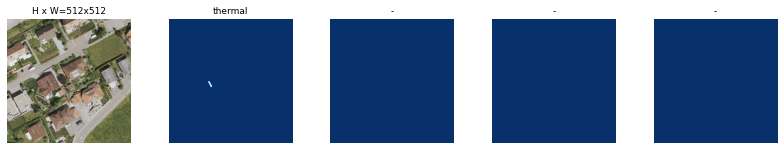

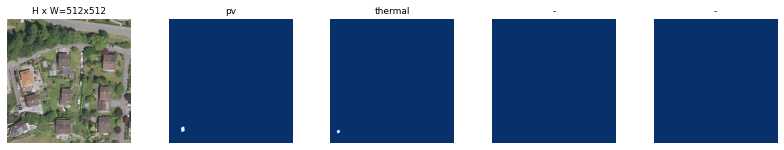

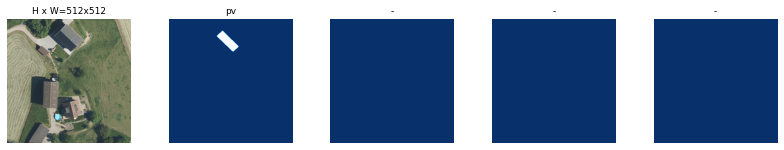

Displaying examples from validation dataset:


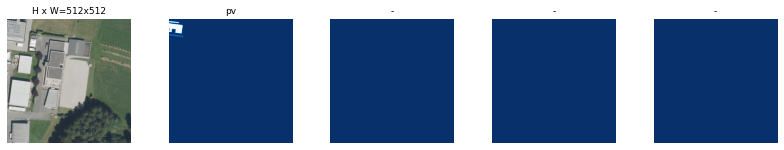

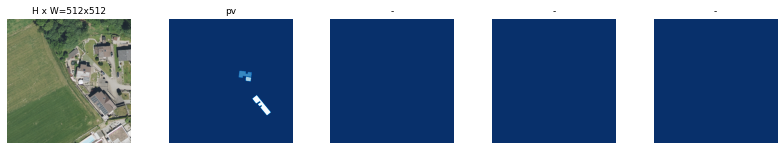

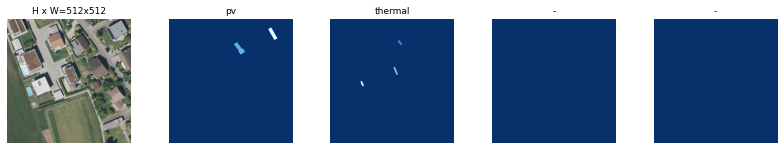

In [7]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook in the Matterport repo.

In [7]:
import tensorflow as tf
import datetime
%load_ext tensorboard

sess = tf.Session()
file_writer = tf.summary.FileWriter('/home/ubuntu/thomas/Mask_RCNN/logs', sess.graph)

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training",
                          config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # coco or last

if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH,
                       by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training
Train in three stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Only 4+ layers.

3. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers='all' to train all layers.

In [28]:
mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(train_model=model,
                                                                        inference_model=model_inference,
                                                                        dataset=dataset_val,
                                                                        calculate_map_at_every_X_epoch=10,
                                                                        dataset_limit=None,
                                                                        verbose=1)                                                                        

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            #custom_callbacks=[mean_average_precision_callback],
            layers='heads') 
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [ ]:
# 4+ layers
start_train = time.time()
model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=24, 
            #custom_callbacks=[mean_average_precision_callback],
            layers="4+")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [ ]:
# Fine tune all layers
start_train = time.time()
model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE/10,
            epochs=100, 
            #custom_callbacks=[mean_average_precision_callback],
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')